# Validation

In this notebook, we undertake some model validation.
This is done through the use of visualisations.
We hope to see that the patterns produced by the model are in some way similar to those found in the data.

## Importing modules and packages

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
from tqdm import tqdm

%matplotlib inline

sys.path.append('../../../stationsim/')
from stationsim_gcs_model import Model

## Functions

## Paths and directories

In [2]:
# Input and output parent directories
input_dir = '../inputs/'
output_dir = '../outputs/'

In [3]:
# Frames directories
frames_dir = input_dir + 'frames/'
output_frames_dir = output_dir + 'frames/'
if not os.path.exists(output_frames_dir):
    os.makedirs(output_frames_dir)

In [4]:
# Frames paths
frame_files = [f for f in os.listdir(frames_dir) if f.endswith('.dat')]
frame_paths = [frames_dir + f for f in frame_files]

# Change .dat to .csv for outputs
output_frame_files = [f[:-4] + '.csv' for f in frame_files]
output_frame_paths = [output_frames_dir + f for f in frame_files]

In [5]:
# Combined frames data
total_frames_path = output_dir + 'combined_frames.csv'

In [ ]:
fig_dir = '../outputs/figures/validation/'

## Reading in data

In [6]:
total_data = pd.read_csv(total_frames_path)
total_data.head()

,frame,pedestrianID,x,y
0,5327,245,563.110625,676.817906
1,5327,246,534.003343,631.251565
2,462,198,49.431612,296.911898
3,462,199,539.377299,88.443098
4,462,208,486.787285,560.910907


## Running models

In [7]:
model_params = {'station': 'Grand_Central',
                'speed_mean': 0.8974784080646091,
                'speed_std': 0.3719712250899986,
                'speed_min': 0.174302,
                'birth_rate': 1.6,
                'step_limit': 20000,
                'do_print': False,
                'pop_total': 274}

In [8]:
model = Model(**model_params)

In [9]:
for _ in tqdm(range(model.step_limit)):
    model.step()

100%|██████████████████████████████████████████████████████████████| 20000/20000 [02:48<00:00, 118.49it/s]


## Plotting data and models

### Model

#### Trails

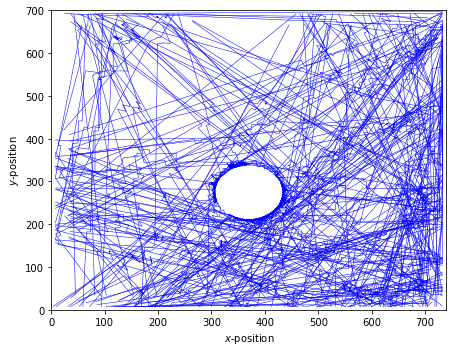

In [26]:
plt.figure(figsize=(6.4, 5))
for agent in model.agents:
    locs = np.array(agent.history_locations).T
    plt.plot(*locs, linewidth=0.5, c='blue')

plt.ylim(0, 700)
plt.xlim(0, 740)
plt.ylabel('$y$-position')
plt.xlabel('$x$-position')
plt.tight_layout()
plt.show()

#### Trail density

In [27]:
history_locs = []
for agent in model.agents:
    for loc in agent.history_locations:
        if None not in loc:
            history_locs.append(loc)

history_locs = np.array(history_locs).T
xs, ys = history_locs[0], history_locs[1]

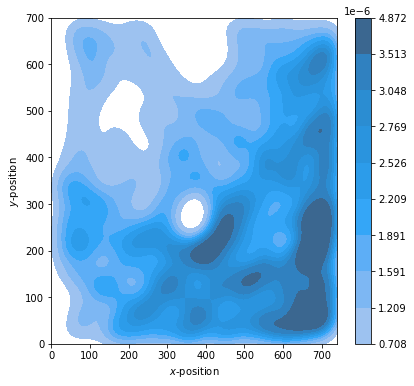

In [28]:
# Model
plt.figure(figsize=(6.4, 6))
sns.kdeplot(x=xs, y=ys, fill=True, cbar=True)
plt.xlim(0, 740)
plt.ylim(0, 700)
plt.xlabel('$x$-position')
plt.ylabel('$y$-position')
plt.show()

#### Time in system

In [29]:
times_in_system = list()

for agent in model.agents:
    time_in_system = agent.step_end - agent.step_start
    times_in_system.append(time_in_system)

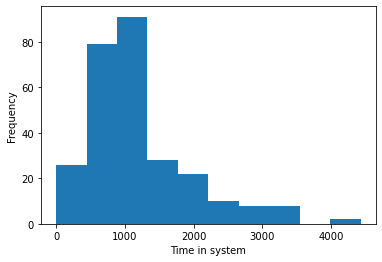

In [30]:
plt.figure()
plt.hist(times_in_system)
plt.xlabel('Time in system')
plt.ylabel('Frequency')
plt.show()

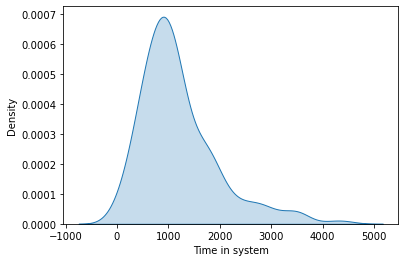

In [31]:
plt.figure()
sns.kdeplot(times_in_system, fill=True)
plt.xlabel('Time in system')
plt.ylabel('Density')
plt.show()

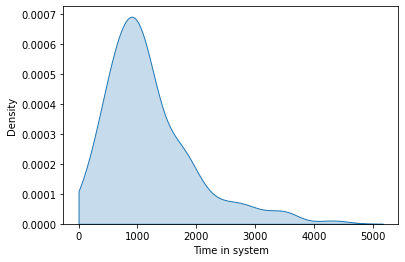

In [32]:
plt.figure()
sns.kdeplot(times_in_system, fill=True, clip=(0, 6000))
plt.xlabel('Time in system')
plt.ylabel('Density')
plt.show()

### Data

#### Trails

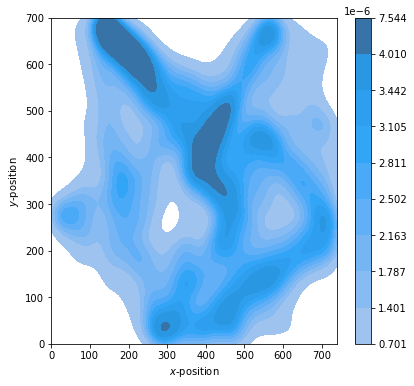

In [33]:
# Data
plt.figure(figsize=(6.4, 6))
sns.kdeplot(x='x', y='y', data=total_data, fill=True, cbar=True)
plt.xlim(0, 740)
plt.ylim(0, 700)
plt.xlabel('$x$-position')
plt.ylabel('$y$-position')
plt.show()

#### Trail density

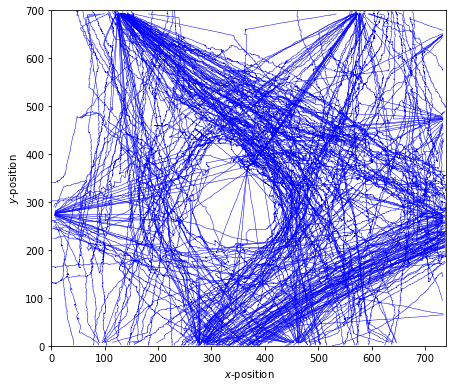

In [34]:
pedestrian_ids = total_data['pedestrianID'].unique()

plt.figure(figsize=(6.4, 5.5))

for pid in pedestrian_ids:
    tdf = total_data.loc[total_data['pedestrianID']==pid, :]
    tdf_sorted = tdf.sort_values(by='frame')
    plt.plot(tdf_sorted['x'], tdf_sorted['y'], c='blue', linewidth=0.5)

plt.ylim(0, 700)
plt.xlim(0, 740)
plt.ylabel('$y$-position')
plt.xlabel('$x$-position')
plt.tight_layout()
plt.show()

#### Time in system

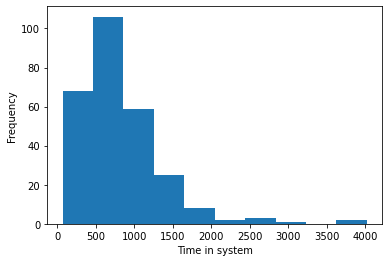

In [35]:
pedestrian_ids = total_data['pedestrianID'].unique()

obs_times_in_system = list()

for pid in pedestrian_ids:
    tdf = total_data.loc[total_data['pedestrianID']==pid, :]
    time_in_system = tdf['frame'].max() - tdf['frame'].min()
    obs_times_in_system.append(time_in_system)

plt.figure()
plt.hist(obs_times_in_system)
plt.ylabel('Frequency')
plt.xlabel('Time in system')
plt.show()

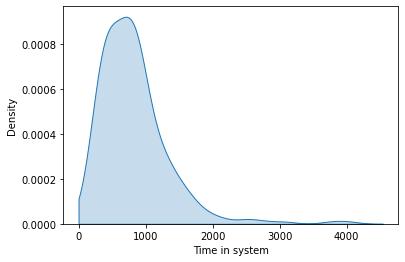

In [36]:
plt.figure()
sns.kdeplot(obs_times_in_system, fill=True, clip=(0, 6000))
plt.xlabel('Time in system')
plt.ylabel('Density')
plt.show()

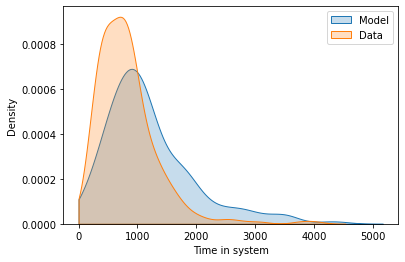

In [37]:
plt.figure()
sns.kdeplot(times_in_system, fill=True, clip=(0, 6000), label='Model')
sns.kdeplot(obs_times_in_system, fill=True, clip=(0, 6000), label='Data')
plt.xlabel('Time in system')
plt.ylabel('Density')
plt.legend()
plt.show()

## Statistical hypothesis testing

In [22]:
from scipy.stats import mannwhitneyu, kruskal, wilcoxon

In [23]:
t = mannwhitneyu(times_in_system, obs_times_in_system)
t

MannwhitneyuResult(statistic=50235.5, pvalue=7.33248638907756e-12)

In [24]:
t = kruskal(times_in_system, obs_times_in_system)
t

KruskalResult(statistic=46.9401824333445, pvalue=7.318668727306708e-12)

In [25]:
t = wilcoxon(times_in_system, obs_times_in_system)
t

WilcoxonResult(statistic=10572.0, pvalue=3.059315995039919e-10)